# Inverse kinematics for the modified Braccio

## Import the SymPy library

In [1]:
from sympy import *
#var('d,a,alpha,delta,Rz,Rx,Tz,Tx')
def d2r(deg):
    return deg/180*pi

## Define the DH-parameter


In [2]:
d1=70
a2=125
a3=125
a4=90
d5=150

## Backward transformation
Specification of the target vector w from 3 spatial coordinates and 3 rotation angles. It is preceded by a 0th element with 0 to make it easier to work with the indexes. This achieves a match with the numbering in the documented calculation algorithm.
The target vector w consists of the three location coordinates of the gripper and its orientation. 

In [17]:
def BraccioInverse(w):
    # q is the vector containing the joint angles
    q=Matrix([0,0,0,0,0,0])
    
    # base joint
    q[1]= atan2(w[2],w[1])
    # print("q1=" +str(q[1]))

    # ellbow joint
    q234 =atan2(-w[4]*cos(q[1]) - w[5]*sin(q[1]), -w[6])
    # print("q234=" +str(q234))
    
    # introduce intermediate values
    b1 = w[1]*cos(q[1]) + w[2]*sin(q[1]) - a4*cos(q234) + d5*sin(q234)
    b2 = d1 - a4*sin(q234) - d5*cos(q234) - w[3]   
    bb = (b1**2) + (b2**2)
    q[3] = acos((bb - (a2**2) - (a3**2)) / (2*a2*a3)) # "-" gives the elbow down variant
    # print("q3=" +str(q[3]))

    # shoulder
    q[2] = atan2((a2 + a3*cos(q[3]))*b2 - a3*sin(q[3])*b1,
                  (a2+a3*cos(q[3]))*b1 + a3*sin(q[3])*b2)
    # print("q2=" +str(q[2]))

    # wrist angle
    q[4] = (q234 - q[2] - q[3] ) 
    # print("q4=" +str(q[4]))

    # wrist twist angle
    # calculate q5 with reference to CS 5 / z5
    #q[5] = pi*log( sqrt( w[4]**2 + w[5]**2 + w[6]**2))
    
    # calculate q5 with reference to CS 0 / z0
    q[5] = q[1] + pi*log( sqrt( w[4]**2 + w[5]**2 + w[6]**2))
    q[5] = q[5] % pi

    #print("q5=" +str(q[5]))

    # Adapt to the offsets of the actuators between the lectures' sketch and the robot
    q[1] = q[1] + 0
    q[2] = q[2] + 2*pi/2
    q[3] = q[3] + 1*pi/2
    q[4] = q[4] + 1*pi/2
    q[5] = q[5] - 0
    #print(q)
    return q
    
def genBraccioString(q):
    # function to generate the string for the serial communication with the robot
    # convert radiant to degrees
    q_deg=N(q/pi*180)
    # print(q_deg)
    
    # generate the robot string
    go = True
    for angle in q_deg:
        #print(angle)
        try: #if something goes wrong, the script won't stop
            if not 0 <= angle <= 180:
               #print(angle)
               go=False
               break
        except:
                go=False
                break
    if go:
        command="P"+str(int(q_deg[1]))+"," \
                +str(int(q_deg[2]))+"," \
                +str(int(q_deg[3]))+","\
                +str(int(q_deg[4]))+","\
                +str(int(q_deg[5]))+",100,50\n"
       # print(angles)
    else: 
        #print("not in range")
        command = None
    return command

In [29]:
# test the stuff
w1=Matrix([0,a3+a4,0,d1+a2-d5,0,0,-1]) # 0*pi/2,0,0*pi/2])
#w1=Matrix([0,210,0,0,0,0,-1])
print(w1)
print(genBraccioString(BraccioInverse(w1)))

Matrix([[0], [215], [0], [45], [0], [0], [-1]])
P0,90,180,90,0,100,50



## Connect to the robot

In [26]:
import serial
import time
s = serial.Serial('COM6', 115200, timeout=5)
time.sleep(3)                

In [27]:
# Home Position
s.write(b'P0,90,180,90,0,40,30')
print(s.readline().decode())

OK



In [28]:
# Null-Position
s.write(b'P0,90,180,90,0,60,30')
print(s.readline().decode())

OK



## Test the backward kineamtics

In [30]:
w=Matrix([0,0,220,100,0,0,-exp(1/2)])
angles = genBraccioString(BraccioInverse(w))
if angles:
    print(angles, end = " ")
    s.write(angles.encode('ascii'))
    print(s.readline().decode())
else:
    print("not in range")


P90,98,144,116,0,100,50
 OK



## Script for scanning the robots workspace

In [31]:
print("Start iteration")
posx= []
posy= []
for x in range(-270,270,30): #-270,270,50):
    for y in range(-270,+270,30): #-300,300,50):
        w=Matrix([0,x,y,80,0,0,-exp(1/2)])
        angles=genBraccioString(BraccioInverse(w))
        print("x="+str(x)+" " + "y=" + str(y) , end=" ")#+s.readline().decode())   
        if angles:
            posx.append(x)
            posy.append(y)
            s.write(angles.encode('ascii'))
            s.readline()
            print(": " + angles, end=" ")
        else:
            print(": ---")
print("Fertig")

Start iteration
x=-270 y=-270 : ---
x=-270 y=-240 : ---
x=-270 y=-210 : ---
x=-270 y=-180 : ---
x=-270 y=-150 : ---
x=-270 y=-120 : ---
x=-270 y=-90 : ---
x=-270 y=-60 : ---
x=-270 y=-30 : ---
x=-270 y=0 : P180,122,121,116,90,100,50
 x=-270 y=30 : P173,124,118,116,83,100,50
 x=-270 y=60 : P167,128,111,120,77,100,50
 x=-270 y=90 : ---
x=-270 y=120 : ---
x=-270 y=150 : ---
x=-270 y=180 : ---
x=-270 y=210 : ---
x=-270 y=240 : ---
x=-240 y=-270 : ---
x=-240 y=-240 : ---
x=-240 y=-210 : ---
x=-240 y=-180 : ---
x=-240 y=-150 : ---
x=-240 y=-120 : ---
x=-240 y=-90 : ---
x=-240 y=-60 : ---
x=-240 y=-30 : ---
x=-240 y=0 : P180,104,147,108,90,100,50
 x=-240 y=30 : P172,105,146,108,82,100,50
 x=-240 y=60 : P165,108,142,109,75,100,50
 x=-240 y=90 : P159,113,135,111,69,100,50
 x=-240 y=120 : P153,121,123,115,63,100,50
 x=-240 y=150 : ---
x=-240 y=180 : ---
x=-240 y=210 : ---
x=-240 y=240 : ---
x=-210 y=-270 : ---
x=-210 y=-240 : ---
x=-210 y=-210 : ---
x=-210 y=-180 : ---
x=-210 y=-150 : ---
x=-210

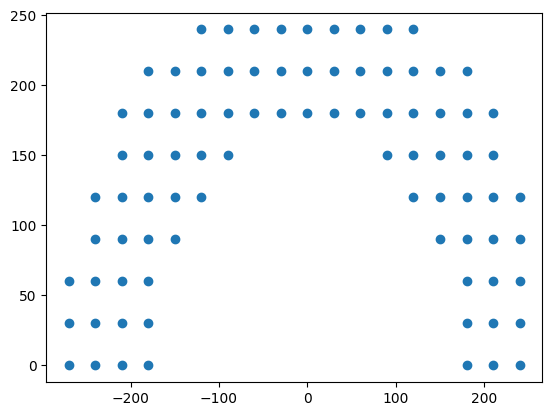

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(posx,posy)

## Close the serial connection

In [130]:
s.close()